In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import Config
from datetime import datetime
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import show_img_tensor_CHW
from fliker_comment_tokenizer import FlikerCommentTokenizer
from fliker_img_comment_dataset import ImgCommentDataset
from model_util import count_parameters
from pathlib import Path
from text_token_embedding import TextTokenEmbedding
from text_casual_mask_transformer import TextMaskedTransformer
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from vlm_model import ImgLanguageModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import DataLoader
import torchvision.transforms.functional as VF



plt.rcParams["savefig.bbox"] = 'tight'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
config = Config()

train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset = ImgCommentDataset(config, split="test")
print(f"train_dataset:  {len(train_dataset)}")
print(f"eval_dataset:  {len(eval_dataset)}")
print(f"test_dataset:  {len(test_dataset)}")


# Data Loader
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"train_dataloader:  {len(train_dataloader)}")
print(f"eval_data_loader:  {len(eval_dataloader)}")
print(f"test_data_loader:  {len(test_dataloader)}")

Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
train_dataset:  114418
eval_dataset:  28605
test_dataset:  15892
train_dataloader:  5721
eval_data_loader:  1431
test_data_loader:  795


In [5]:
# class ImgCaptionModel(nn.Module):
#     def __init__(self, config: Config, tokenizer):
#         super().__init__()

#         assert config is not None
#         assert (
#             config.img_patch_embedding == config.text_token_embedding
#         ), f"img_patch_embedding: {config.img_patch_embedding} should be same as text_token_embedding: {config.text_token_embedding}"

#         self.config = config
#         self.tokenizer = tokenizer

#         # ---------------------------------------------------------
#         # [<imge> x IMG_PATCHES][<bos>][TEXT_TOKEN_EMB x N][<pad>*]
#         # ---------------------------------------------------------
#         #           i0  i1  b   t1  t2  t3
#         # <image> | 1,  1,  1,  1,  1,  1 |
#         # <image> | 1,  1,  1,  1,  1,  1 |
#         # <bos>   | 1,  1,  1,  1,  1,  1 |
#         # t1      | 1,  1,  1,  0,  0,  0 |
#         # t2      | 1,  1,  1,  1,  0,  0 |
#         # t3      | 1,  1,  1,  1,  1,  0 |
#         self.img_bos_mask = torch.ones(
#             size=(config.img_patches + 1, config.img_patches + 1 + config.max_text_len)
#         )  # (IMG_PATCHES + 1) x (IMG_PATCHES + 1 + TEXT_TOKENS)
#         self.text_mask = torch.hstack(
#             [
#                 torch.ones(size=(config.max_text_len, config.img_patches + 1)),
#                 torch.tril(torch.ones(size=(config.max_text_len, config.max_text_len)))
#                 - torch.eye(config.max_text_len),
#             ]
#         )
#         self.mask = torch.vstack([self.img_bos_mask, self.text_mask])
#         self.transformer = TextMaskedTransformer(config=config, mask=self.mask)
#         self.lm_head = nn.Linear(
#             config.text_token_embedding, tokenizer.vocab_size, bias=False
#         )
#         # B x tokens x token_emb @ token_emb x vocab_size => B x tokens x vocab_size

#     def forward(
#         self,
#         img_feature: torch.tensor,
#         text_feature: torch.tensor,
#         text_mask: torch.tensor,
#         target_text_token: torch.tensor,
#         bos_embedding: torch.tensor,
#     ):
#         """
#         inputs:
#             - img_feature: B x IMG_PATCHES x IMG_PATCH_EMB
#             - text_feature: B x TEXT_TOKEN x TEXT_EMB
#             - text_mask: B x TEXT_TOKEN x 1
#             - target_text_token: B x TEXT_TOKEN
#         outputs:
#             - text prediction:
#             - loss
#         """
#         bos_embedding = bos_embedding.view(1, 1, -1)  # 1 x 1 x TEXT_EMB
#         bos_embedding = bos_embedding.to(img_feature.device)
#         assert (
#             len(img_feature.size())
#             == len(bos_embedding.size())
#             == len(text_feature.size())
#         )
#         bos_embedding_ext = bos_embedding.expand(img_feature.size()[0], -1, -1)
#         x = torch.cat(
#             [img_feature, bos_embedding_ext, text_feature], dim=1
#         )  # B x [IMG_PATCHES + 1 + TEXT_TOKEN] x IMG_PATCH_EMB
#         x = self.transformer(
#             x=x, need_embedding=False
#         )  # B x [IMG_PATCHES + 1 + TEXT_TOKEN] x IMG_PATCH_EMB
#         x = self.lm_head(x)  # B x [IMG_PATCHES + 1 + TEXT_TOKEN] x vocab_size

#         if target_text_token is None:
#             loss = None
#         else:
#             # extract the last `self.config.max_text_len` token positions
#             text_pos_mask = torch.arange(start=-config.max_text_len, end=0, step=1)
#             text_logits = x[:, text_pos_mask, :]  # B x TEXT_TOKEN x vocab_size
#             B, TEXT_TOKEN, vocab_size = text_logits.size()
#             text_logits = text_logits.view(B * TEXT_TOKEN, -1)
#             target_text_token = target_text_token.view(B * TEXT_TOKEN)
#             loss = F.cross_entropy(text_logits, target_text_token, reduction="mean")

#         return text_logits, loss


# class ImgLanguageModel(nn.Module):
#     def __init__(self, config: Config):
#         super().__init__()
#         self.config = config

#         self.img_embedding = ImageEmbedding(config=config)
#         self.img_transfomer = ImgTransformer(config=config)
#         self.img_flatten = nn.Flatten(start_dim=1)
#         self.img_proj = nn.Linear(
#             in_features=config.img_patch_embedding,
#             out_features=config.img_text_proj_features,
#         )
#         self.img_softmax = nn.LogSoftmax(dim=-1)
#         self.img_norm = nn.LayerNorm(config.img_patch_embedding)

#         # self.text_embedding = TextTokenEmbedding(config=config)
#         self.text_transformer = TextMaskedTransformer(config=config)
#         self.text_flatten = nn.Flatten(start_dim=1)
#         self.text_norm = nn.LayerNorm(config.text_token_embedding)
#         self.text_proj = nn.Linear(
#             in_features=config.text_token_embedding,
#             out_features=config.img_text_proj_features,
#         )
#         self.text_softmax = nn.LogSoftmax(dim=-1)

#         self.diag_mask = torch.diag(torch.ones(config.img_text_proj_features))
#         self.loss_fn = nn.NLLLoss()
#         self.bce_loss_fn = torch.nn.BCEWithLogitsLoss()

#         self.bos_token = self.text_transformer.text_token_embedding.text_encoder.encode(
#             "<bos>"
#         )[
#             1
#         ]  # return <bos><bos>
#         self.img_caption_model = ImgCaptionModel(
#             config=config,
#             tokenizer=self.text_transformer.text_token_embedding.text_encoder,
#         )

#     def forward(
#         self,
#         batch_img_tensor: torch.tensor,
#         batch_text_tensor: torch.tensor,
#         batch_text_mask_tensor: torch.tensor,
#         batch_img_id_tensor: torch.tensor = None,
#     ):
#         """
#         batch_img_tensor: B x IMG_PATCHES x IMG_EMB
#         batch_text_tensor: B x TEXT_TOKEN
#         batch_text_mask_tensor: B x TEXT_TOKEN
#         """
#         img_embedding = self.img_embedding(
#             batch_img_tensor
#         )  # B x IMG_PATCHES x IMG_EMB
#         # print(f"img_encoding: {img_embedding.size()}")

#         img_feature = self.img_transfomer(img_embedding)  # B x IMG_PATCHES x IMG_EMB
#         img_feature = self.img_norm(img_feature)  # B x IMG_PATCHES x IMG_EMB
#         img_contrastive_feature = self.img_norm(
#             img_feature[:, -1, :]
#         )  # B x IMG_EMB, take the last one
#         # print(f"img_feature: {img_feature.size()}")

#         # img_feature_flatten = self.img_flatten(img_feature)
#         # print(f"img_feature_flatten: {img_feature_flatten.size()}")

#         img_feature_proj = self.img_proj(img_contrastive_feature)
#         # print(f"img_feature_proj: {img_feature_proj.size()}")  # B x img_text_proj_features

#         # text_embedding = self.text_embedding(batch_text_tensor)
#         # print(f"text_embedding: {text_embedding.size()}")

#         text_feature = self.text_transformer(batch_text_tensor)
#         text_feature = self.text_norm(text_feature)
#         text_contrastive_feature = self.text_norm(
#             text_feature[
#                 torch.arange(text_feature.shape[0]),
#                 torch.argmax(batch_text_mask_tensor, dim=1, keepdim=False),
#             ]
#         )
#         # print(f"text_feature: {text_feature.size()}")

#         # text_feature_flatten = self.text_flatten(text_feature)
#         # print(f"text_feature_flatten: {text_feature_flatten.size()}")

#         text_feature_proj = self.text_proj(text_contrastive_feature)
#         # print(f"text_feature_proj: {text_feature_proj.size()}")  # B x img_text_proj_features

#         # Contrastive learning
#         contrastive_scores = img_feature_proj @ text_feature_proj.T
#         # print(f"contractive_scores: {contrastive_scores}")  # B x img_text_proj_features

#         img_contrastive_prob = self.img_softmax(contrastive_scores)
#         # print(f"img_contrastive_prob: {img_contrastive_prob}")  # B x img_text_proj_features

#         # ===============================================================================
#         # Img BCE-Loss
#         # ===============================================================================
#         # target = torch.eye(
#         #     contrastive_scores.size()[0], device=contrastive_scores.device
#         # )
#         # img_loss = self.bce_loss_fn(contrastive_scores, target)
#         # text_loss = self.bce_loss_fn(contrastive_scores.T, target)

#         # ===============================================================================
#         # Img NLL-Loss
#         # ===============================================================================
#         target = torch.arange(
#             img_contrastive_prob.size()[0], device=img_contrastive_prob.device
#         )
#         img_loss = self.loss_fn(img_contrastive_prob, target)
#         # img_loss = self.loss_fn(img_contrastive_prob, self.target.expand(img_contrastive_prob.size()[0], -1))
#         # print(f"img_loss: {img_loss}")

#         text_contrastive_prob = self.text_softmax(contrastive_scores.T)

#         # ===============================================================================
#         # Text NLL-Loss
#         # ===============================================================================
#         # print(f"text_contrastive_prob: {text_contrastive_prob}")  # B x img_text_proj_features
#         text_loss = self.loss_fn(text_contrastive_prob, target)
#         # print(f"text_loss: {text_loss}")

#         bos_embedding = self.text_transformer.text_token_embedding(
#             x=torch.tensor(self.bos_token, device=batch_img_tensor.device),
#             skip_position_embedding=True,
#         )
#         lm_logits, lm_loss = self.img_caption_model(
#             img_feature=img_feature,
#             text_feature=text_feature,
#             text_mask=(batch_text_tensor != 0),
#             target_text_token=batch_text_tensor,
#             bos_embedding=bos_embedding,
#         )
#         # print(f"lm_logits: {lm_logits.size()}")
#         # print(f"lm_loss: {lm_loss}")

#         return (
#             img_loss,
#             text_loss,
#             img_contrastive_prob,
#             text_contrastive_prob,
#             lm_loss,
#             lm_logits,
#         )

In [6]:
# train_dataset = ImgCommentDataset(config, split="train")

# BATCH_SIZE = 10
# train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

batch_img_tensor, batch_img_id_tensor, batch_comment_encoding, batch_text_mask = next(
    iter(train_dataloader)
)
print(f"batch_img_tensor: {batch_img_tensor.size()}")
print(f"batch_img_id_tensor: {batch_img_id_tensor.size()}")
print(f"batch_comment_encoding: {batch_comment_encoding.size()}")
print(f"batch_text_mask: {batch_text_mask.size()}")

tokens: 10000
tokenizer.is_fast: True
batch_img_tensor: torch.Size([20, 3, 224, 224])
batch_img_id_tensor: torch.Size([20])
batch_comment_encoding: torch.Size([20, 50])
batch_text_mask: torch.Size([20, 50])


In [7]:
# model = ImgLanguageModel(config=config)
# img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit = (
#     model(
#         batch_img_tensor=batch_img_tensor,
#         batch_text_tensor=batch_comment_encoding,
#         batch_text_mask_tensor=batch_text_mask,
#         batch_img_id_tensor=batch_img_id_tensor,
#     )
# )
# print(f"img_loss: {img_loss}")
# print(f"text_loss: {text_loss}")
# print(f"lm_loss: {lm_loss}")

# pytorch_total_params = sum(p.numel() for p in model.parameters())
# pytorch_total_trainable_params = sum(
#     p.numel() for p in model.parameters() if p.requires_grad
# )
# print(f"pytorch_total_params: {pytorch_total_params/10**6} m")
# print(f"pytorch_total_trainable_params: {pytorch_total_trainable_params/10**6} m")
# count_parameters(model)

In [8]:
# EPOCHES = 5
# EVAL_INTERVAL = 100
# EVAL_STEPS = 10
# lr = 5e-4
# max_l2_grad_norm = 20
# total_steps = EPOCHES * len(train_dataloader)

# device = torch.device("mps")

# model = model.to(device)
# optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
# # scheduler = torch.optim.lr_scheduler.OneCycleLR(
# #     optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=EPOCHES
# # )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=total_steps,
# )


# def eval(model: ImgLanguageModel, global_step: int, writer: SummaryWriter):
#     model.eval()

#     avg_eval_loss = None
#     eval_loss_std = None
#     img_accuracies = []
#     text_accuracies = []
#     with torch.no_grad():
#         eval_losses = []
#         for i, data in enumerate(eval_dataloader):
#             if i > EVAL_STEPS:
#                 # It takes significant time to do one full eval.
#                 break

#             (
#                 batch_img_tensor,
#                 batch_img_id_tensor,
#                 batch_target_tensor,
#                 batch_target_mask,
#             ) = data
#             (
#                 batch_img_tensor,
#                 batch_img_id_tensor,
#                 batch_text_tensor,
#                 batch_text_mask_tensor,
#             ) = data
#             batch_img_tensor = batch_img_tensor.to(device)
#             batch_img_id_tensor = batch_img_id_tensor.to(device)
#             batch_text_tensor = batch_text_tensor.to(device)
#             batch_text_mask_tensor = batch_text_mask_tensor.to(device)

#             (
#                 img_loss,
#                 text_loss,
#                 img_contrastive_prob,
#                 text_contrastive_prob,
#                 lm_loss,
#                 lm_logit,
#             ) = model(
#                 batch_img_tensor=batch_img_tensor,
#                 batch_text_tensor=batch_text_tensor,
#                 batch_text_mask_tensor=batch_text_mask_tensor,
#                 batch_img_id_tensor=batch_img_id_tensor,
#             )

#             img_pred = torch.argmax(img_contrastive_prob, dim=1).cpu()
#             label_mask = torch.arange(img_pred.size()[0]).cpu()
#             img_accuracy = img_pred == label_mask
#             img_accuracies.extend(img_accuracy)

#             text_pred = torch.argmax(text_contrastive_prob, dim=1).cpu()
#             text_accuracy = text_pred == label_mask
#             text_accuracies.extend(text_accuracy)

#             writer.add_scalar("eval/Img Loss", img_loss, global_step)
#             writer.add_scalar("eval/Text Loss", text_loss, global_step)
#             writer.add_scalar("eval/LM Loss", lm_loss, global_step)
#             eval_losses.append(img_loss + text_loss + lm_loss)
#         eval_losses = torch.tensor(eval_losses)
#         avg_eval_loss = eval_losses.mean()
#         eval_loss_std = eval_losses.std()
#         writer.add_scalar("eval/Loss", avg_eval_loss, global_step)
#         writer.add_scalar("Loss/eval-std", eval_loss_std, global_step)
#         writer.add_scalar(
#             "eval/Img Accuracy",
#             sum(img_accuracies) / len(img_accuracies),
#             global_step,
#         )
#         writer.add_scalar(
#             "eval/Text Accuracy",
#             sum(text_accuracies) / len(text_accuracies),
#             global_step,
#         )
#     model.train()
#     writer.flush()
#     return avg_eval_loss, eval_loss_std


# def train(model: ImgLanguageModel, writer: SummaryWriter):
#     best_vloss = torch.tensor(1_000_000)
#     with torch.profiler.profile(
#         schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
#         on_trace_ready=torch.profiler.tensorboard_trace_handler("./runs"),
#         activities=[torch.profiler.ProfilerActivity.CPU],
#         record_shapes=True,
#         profile_memory=True,
#         with_stack=True,
#     ) as prof:
#         # with torch.mps.profiler.profile(mode="interval", wait_until_completed=False):
#         for epoch in range(EPOCHES):
#             img_accuracies = []
#             text_accuracies = []
#             for train_step, data in enumerate(train_dataloader):
#                 global_step = epoch * len(train_dataloader) + train_step

#                 # Profile
#                 if global_step < 1 + 1 + 3:
#                     prof.step()

#                 (
#                     batch_img_tensor,
#                     batch_img_id_tensor,
#                     batch_text_tensor,
#                     batch_text_mask_tensor,
#                 ) = data
#                 batch_img_tensor = batch_img_tensor.to(device)
#                 batch_img_id_tensor = batch_img_id_tensor.to(device)
#                 batch_text_tensor = batch_text_tensor.to(device)
#                 batch_text_mask_tensor = batch_text_mask_tensor.to(device)

#                 # Viz Model
#                 # if global_step == 0:
#                 #     writer.add_graph(model, (batch_img_tensor, batch_target_tensor))

#                 optimizer.zero_grad()

#                 (
#                     img_loss,
#                     text_loss,
#                     img_contrastive_prob,
#                     text_contrastive_prob,
#                     lm_loss,
#                     lm_logit,
#                 ) = model(
#                     batch_img_tensor=batch_img_tensor,
#                     batch_text_tensor=batch_text_tensor,
#                     batch_text_mask_tensor=batch_text_mask_tensor,
#                     batch_img_id_tensor=batch_img_id_tensor,
#                 )

#                 writer.add_scalar("train/Img Loss", img_loss, global_step)
#                 writer.add_scalar("train/Text Loss", text_loss, global_step)
#                 writer.add_scalar("train/LM Loss", lm_loss, global_step)
#                 writer.add_scalar(
#                     "train/Loss", img_loss + text_loss + lm_loss, global_step
#                 )
#                 writer.add_scalar(
#                     "Learning Rate", scheduler.get_last_lr()[-1], global_step
#                 )
#                 loss = img_loss + text_loss + lm_loss
#                 loss.backward()
#                 # ===============================================================================================================
#                 nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_l2_grad_norm)
#                 # ===============================================================================================================
#                 # Error: command buffer exited with error status.
#                 # The Metal Performance Shaders operations encoded on it may not have completed.
#                 # Error:
#                 # (null)
#                 # Ignored (for causing prior/excessive GPU errors) (00000004:kIOGPUCommandBufferCallbackErrorSubmissionsIgnored)
#                 # <AGXG13XFamilyCommandBuffer: 0xa5e418420>
#                 # label = <none>
#                 # device = <AGXG13XDevice: 0x15430ee00>
#                 #     name = Apple M1 Max
#                 # commandQueue = <AGXG13XFamilyCommandQueue: 0x157a05800>
#                 #     label = <none>
#                 #     device = <AGXG13XDevice: 0x15430ee00>
#                 #         name = Apple M1 Max
#                 # retainedReferences = 1
#                 # ---------------------------------------------------------------------------------------------------------------
#                 optimizer.step()
#                 scheduler.step()

#                 if train_step > 0 and train_step % EVAL_INTERVAL == 0:
#                     avg_vloss, _ = eval(
#                         model=model, global_step=global_step, writer=writer
#                     )

#                     if avg_vloss is not None and avg_vloss < best_vloss:
#                         best_vloss = avg_vloss
#                         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#                         model_path = f"vlm_caption_model_{epoch}_{timestamp}"
#                         torch.save(model.state_dict(), model_path)


# with SummaryWriter(flush_secs=1) as writer:
#     train(model=model, writer=writer)
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     model_path = f"vlm_caption_model_{timestamp}_final"
#     torch.save(model.state_dict(), model_path)

In [9]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_path = f"vlm_contrastive_model_{EPOCHES}_{timestamp}_final"
# torch.save(model.state_dict(), model_path)

In [10]:
def evaluate_model_perf(model_file: str, split: str):
    config = Config
    device = torch.device("mps")

    # Loading Model
    target_model = ImgLanguageModel(config=config)
    target_model.load_state_dict(torch.load(model_file))
    target_model = target_model.to(device)
    target_model.eval()

    # Create Dataset and DataLoader
    BATCH_SIZE = 20
    target_dataset = ImgCommentDataset(config, split=split)
    target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"split:  {split}")
    print(f"target_dataset:  {len(target_dataset)}")
    print(f"target_dataloader:  {len(target_dataloader)}")

    img_losses = []
    text_losses = []
    lm_losses = []
    img_preds = []
    text_preds = []
    img_accuracies = []
    text_accuracies = []
    with torch.no_grad():
        for idx, data in tqdm(
            enumerate(target_dataloader), total=len(target_dataloader)
        ):
            (
                batch_img_tensor,
                batch_img_id_tensor,
                batch_text_tensor,
                batch_text_mask_tensor,
            ) = data
            batch_img_tensor = batch_img_tensor.to(device)
            batch_img_id_tensor = batch_img_id_tensor.to(device)
            batch_text_tensor = batch_text_tensor.to(device)
            batch_text_mask_tensor = batch_text_mask_tensor.to(device)
            (
                img_loss,
                text_loss,
                img_contrastive_prob,
                text_contrastive_prob,
                lm_loss,
                lm_logit,
            ) = target_model(
                batch_img_tensor=batch_img_tensor,
                batch_text_tensor=batch_text_tensor,
                batch_text_mask_tensor=batch_text_mask_tensor,
                batch_img_id_tensor=batch_img_id_tensor,
            )
            img_losses.append(img_loss.cpu())
            text_losses.append(text_loss.cpu())
            lm_losses.append(lm_loss.cpu())

            img_pred = torch.argmax(img_contrastive_prob, dim=1).cpu()
            img_preds.extend(img_pred)

            text_pred = torch.argmax(text_contrastive_prob, dim=1).cpu()
            text_preds.extend(text_pred)

            label_mask = torch.arange(img_pred.size()[0]).cpu()
            img_accuracy = img_pred == label_mask
            img_accuracies.extend(img_accuracy)

            text_accuracy = text_pred == label_mask
            text_accuracies.extend(text_accuracy)

            # if idx > 5:
            #     break

    img_losses = torch.tensor(img_losses)
    text_losses = torch.tensor(text_losses)
    lm_losses = torch.tensor(lm_losses)
    return (
        img_losses,
        text_losses,
        lm_losses,
        img_preds,
        text_preds,
        img_accuracies,
        text_accuracies,
    )


def viz_loss(title: str, img_losses, text_losses, lm_losses, bins=100):
    # fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df = pd.DataFrame(
        {
            "img_losses": np.array(img_losses),
            "text_losses": np.array(text_losses),
            "lm_losses": np.array(lm_losses),
        }
    )
    df.hist(bins=bins)
    # set title and axis labels
    plt.suptitle(title, x=0.5, y=1.05, ha="center", fontsize="small")
    # fig.text(0.5, 0.04, 'common X', ha='center')
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')


def viz_predictions(title: str, img_preds, text_preds, bins=BATCH_SIZE):
    # fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df = pd.DataFrame(
        {
            "img_preds": np.array(img_preds),
            "text_preds": np.array(text_preds),
        }
    )
    df.hist(bins=bins)
    # set title and axis labels
    plt.suptitle(title, x=0.5, y=1.05, ha="center", fontsize="small")
    # fig.text(0.5, 0.04, 'common X', ha='center')
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [03:57<00:00,  3.35it/s]


img_losses: mean-2.935887098312378, std-0.1714770793914795
text_losses: mean-2.9115326404571533, std-0.1744033843278885
lm_losses: mean-0.08892937749624252, std-0.04911666736006737
img accuracy: 0.07601308822631836
text accuracy: 0.07318147271871567


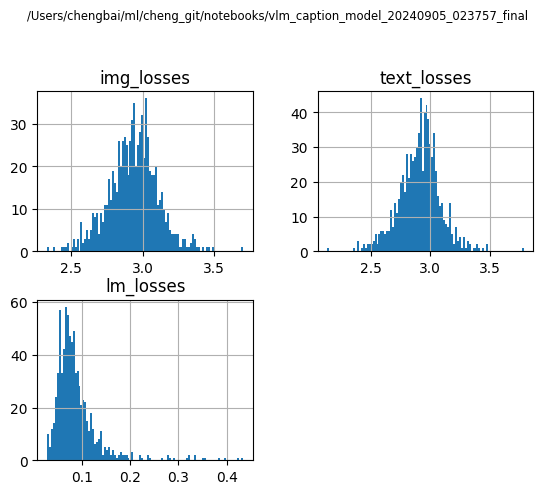

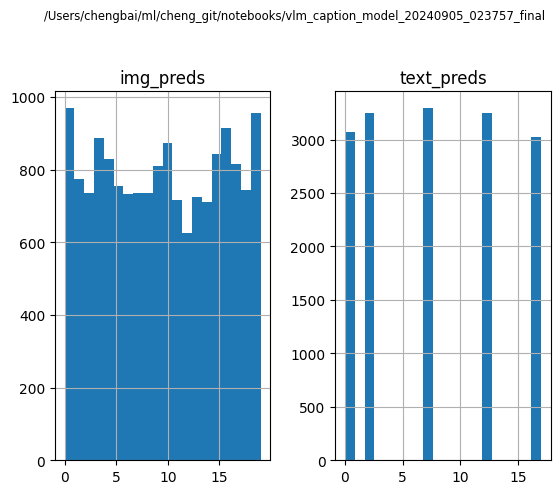

In [11]:
model_file = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20240905_023757_final"
)
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [03:56<00:00,  3.37it/s]


img_losses: mean-2.926727294921875, std-0.2024785429239273
text_losses: mean-2.890638828277588, std-0.20288899540901184
lm_losses: mean-0.021333353593945503, std-0.062381356954574585
img accuracy: 0.08771709352731705
text accuracy: 0.07620186358690262


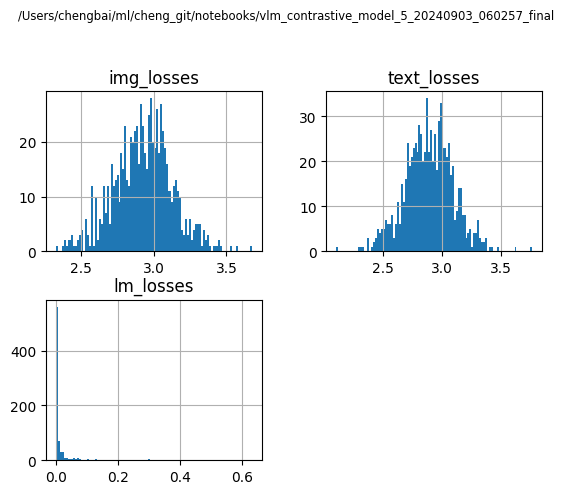

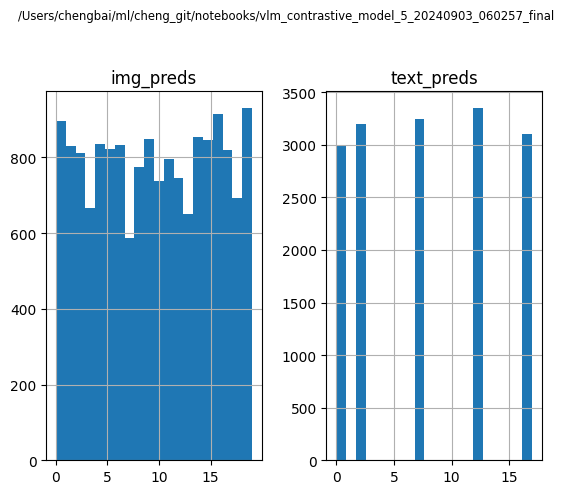

In [ ]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_5_20240903_060257_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [04:01<00:00,  3.29it/s]


img_losses: mean-2.9592390060424805, std-0.09932839125394821
text_losses: mean-2.9480690956115723, std-0.09810122847557068
lm_losses: mean-0.79759281873703, std-0.16128289699554443
img accuracy: 0.06984646618366241
text accuracy: 0.060281902551651


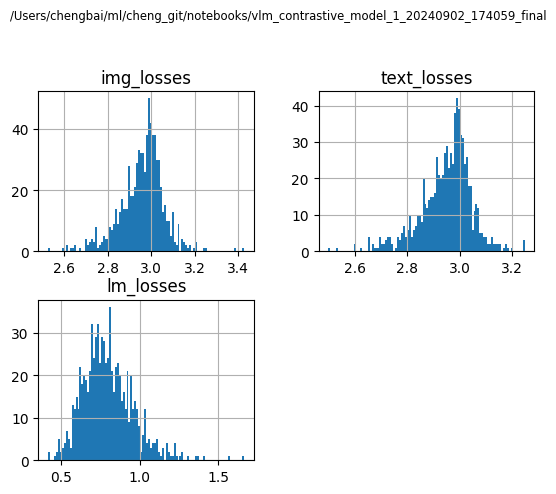

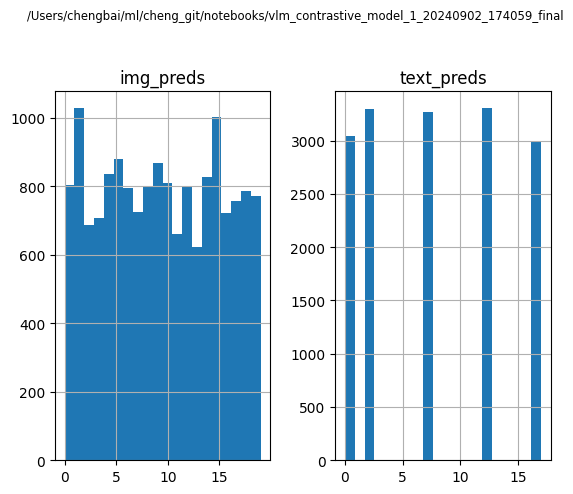

In [ ]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_1_20240902_174059_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

In [10]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_5_20240901_234713_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True


RuntimeError: Error(s) in loading state_dict for ImgLanguageModel:
	Missing key(s) in state_dict: "img_norm.weight", "img_norm.bias", "text_norm.weight", "text_norm.bias". 
	size mismatch for img_proj.weight: copying a param with shape torch.Size([1024, 142688]) from checkpoint, the shape in current model is torch.Size([1024, 728]).
	size mismatch for text_proj.weight: copying a param with shape torch.Size([1024, 36400]) from checkpoint, the shape in current model is torch.Size([1024, 728]).

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 10000
tokenizer.is_fast: True
split:  test
target_dataset:  15892
target_dataloader:  795


100%|██████████| 795/795 [04:14<00:00,  3.13it/s]


img_losses: mean-10.27953052520752, std-2.624840021133423
text_losses: mean-2.229250431060791, std-0.5986806750297546
lm_losses: mean-0.0012080925516784191, std-0.004216477274894714
img accuracy: 0.050969041883945465
text accuracy: 0.051157813519239426


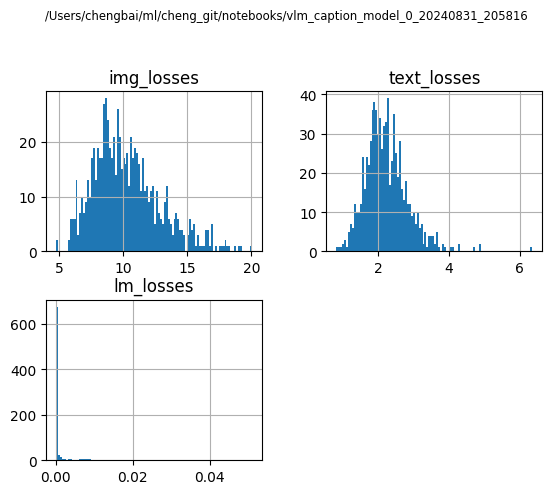

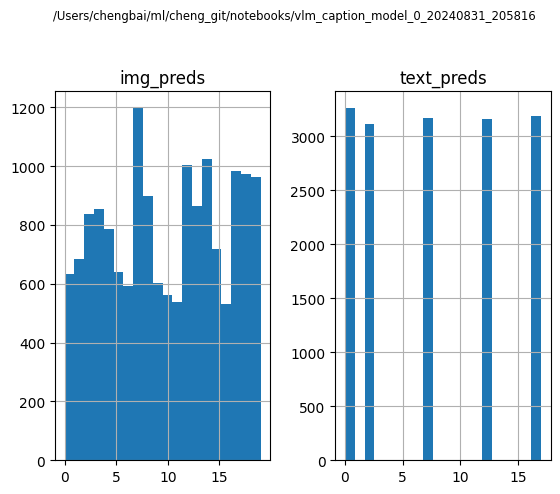

In [ ]:
model_file = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_0_20240831_205816"
)
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 10000
tokenizer.is_fast: True
split:  test
target_dataset:  15892
target_dataloader:  795


100%|██████████| 795/795 [04:09<00:00,  3.19it/s]


img_losses: mean-0.5474981665611267, std-0.2033354938030243
text_losses: mean-0.3965409994125366, std-0.09175096452236176
lm_losses: mean-0.0007577572832815349, std-0.004581856075674295
img accuracy: 0.05336018279194832
text accuracy: 0.050843190401792526


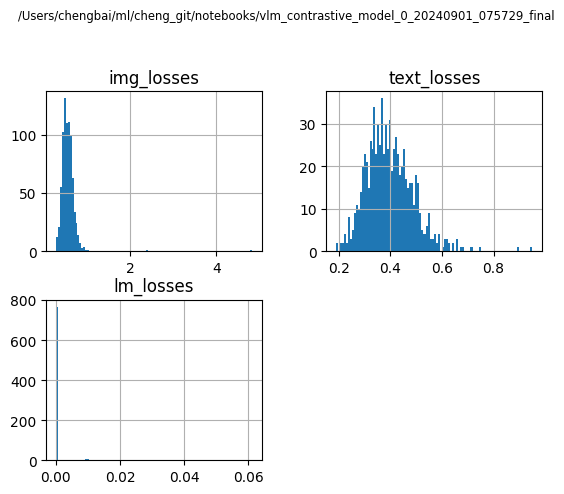

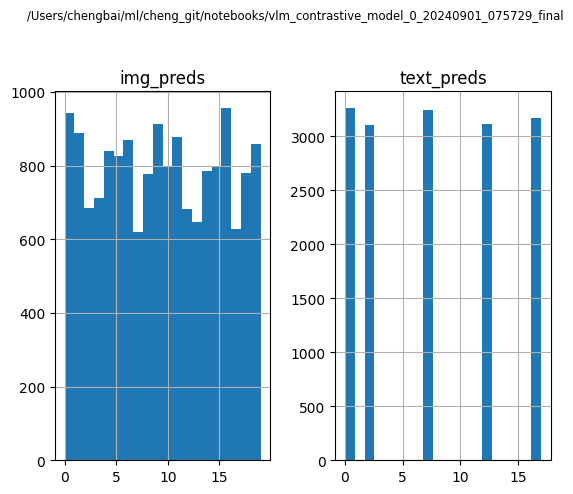

In [14]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_0_20240901_075729_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

In [12]:
device = torch.device("mps")
model_path = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20240905_023757_final"
)
model_trained = ImgLanguageModel(config=config)
model_trained.load_state_dict(torch.load(model_path))
model_trained = model_trained.to(device)
model_trained.eval()

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True


ImgLanguageModel(
  (img_embedding): ImageEmbedding(
    (conv): Conv2d(3, 728, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    (pos_embedding): Embedding(196, 728)
  )
  (img_transfomer): ImgTransformer(
    (blocks): Sequential(
      (0): ImgTransformerBlock(
        (multihead_attention): ImgMultiheadSelfAttention(
          (wq): Linear(in_features=728, out_features=728, bias=True)
          (wk): Linear(in_features=728, out_features=728, bias=True)
          (wv): Linear(in_features=728, out_features=728, bias=True)
          (softmax): Softmax(dim=-1)
          (out_proj): Linear(in_features=728, out_features=728, bias=True)
        )
        (norm1): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
        (linear1): Linear(in_features=728, out_features=2912, bias=True)
        (linear2): Linear(in_features=2912, out_features=728, bias=True)
        (mlp): Sequential(
          (0): Linear(in_

In [39]:
BATCH_SIZE = 10
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"train_dataloader:  {len(train_dataloader)}")
print(f"eval_data_loader:  {len(eval_dataloader)}")
print(f"test_data_loader:  {len(test_dataloader)}")

batch_img_tensor, batch_img_id_tensor, batch_target_tensor, batch_target_mask_tensor = (
    next(iter(test_dataloader))
)
batch_img_tensor = batch_img_tensor.to(device)
batch_target_tensor = batch_target_tensor.to(device)
batch_target_mask_tensor = batch_target_mask_tensor.to(device)
img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit = (
    model_trained(batch_img_tensor, batch_target_tensor, batch_target_mask_tensor)
)

train_dataloader:  11442
eval_data_loader:  2861
test_data_loader:  1590


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06807828..1.0000002].


img_loss: 2.211434841156006
text_loss: 2.235949993133545
lm_loss: 0.09425202757120132


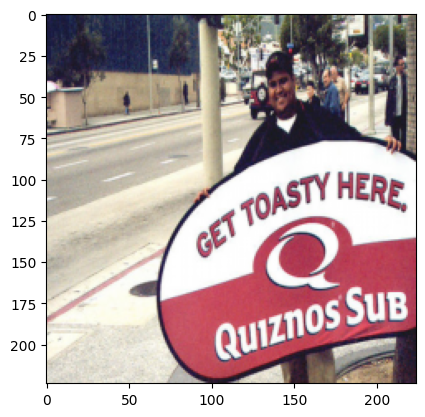

In [41]:
print(f"img_loss: {img_loss}")
print(f"text_loss: {text_loss}")
print(f"lm_loss: {lm_loss}")
show_img_tensor_CHW(batch_img_tensor[9].cpu())

In [42]:
img_contrastive_prob[0]

tensor([-4.3218, -3.5805, -3.6165, -4.0637, -1.1360, -3.2508, -0.9035, -3.3544,
        -2.3268, -4.0579], device='mps:0', grad_fn=<SelectBackward0>)

In [43]:
img_contrastive_prob[0].max()

tensor(-0.9035, device='mps:0', grad_fn=<MaxBackward1>)

In [44]:
label_mask = torch.arange(BATCH_SIZE, device=device)
img_pred = torch.argmax(img_contrastive_prob, dim=1)
img_accuracy = img_pred == label_mask
img_pred, img_accuracy.sum()

(tensor([6, 0, 5, 2, 4, 5, 6, 8, 2, 9], device='mps:0'),
 tensor(4, device='mps:0'))

In [45]:
model_trained.text_transformer.text_token_embedding.text_encoder.decode(
    batch_target_tensor[-1]
)

'<bos>Quiznos worker wearing sign .<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [46]:
def show(imgs, comments, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    imgs_per_row = 1
    fix, axs = plt.subplots(
        nrows=(len(imgs) + imgs_per_row - 1) // imgs_per_row,
        ncols=imgs_per_row,
        squeeze=False,
        figsize=(16, 60),
    )
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        row = i // imgs_per_row
        col = i % imgs_per_row
        axs[row, col].imshow(np.asarray(img))
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        title = f'pred: {comments[i].replace("<pad>", "").replace("<bos>", "")}\nlabel: {labels[i].replace("<pad>", "").replace("<bos>", "")}'
        axs[row, col].set_title(title)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

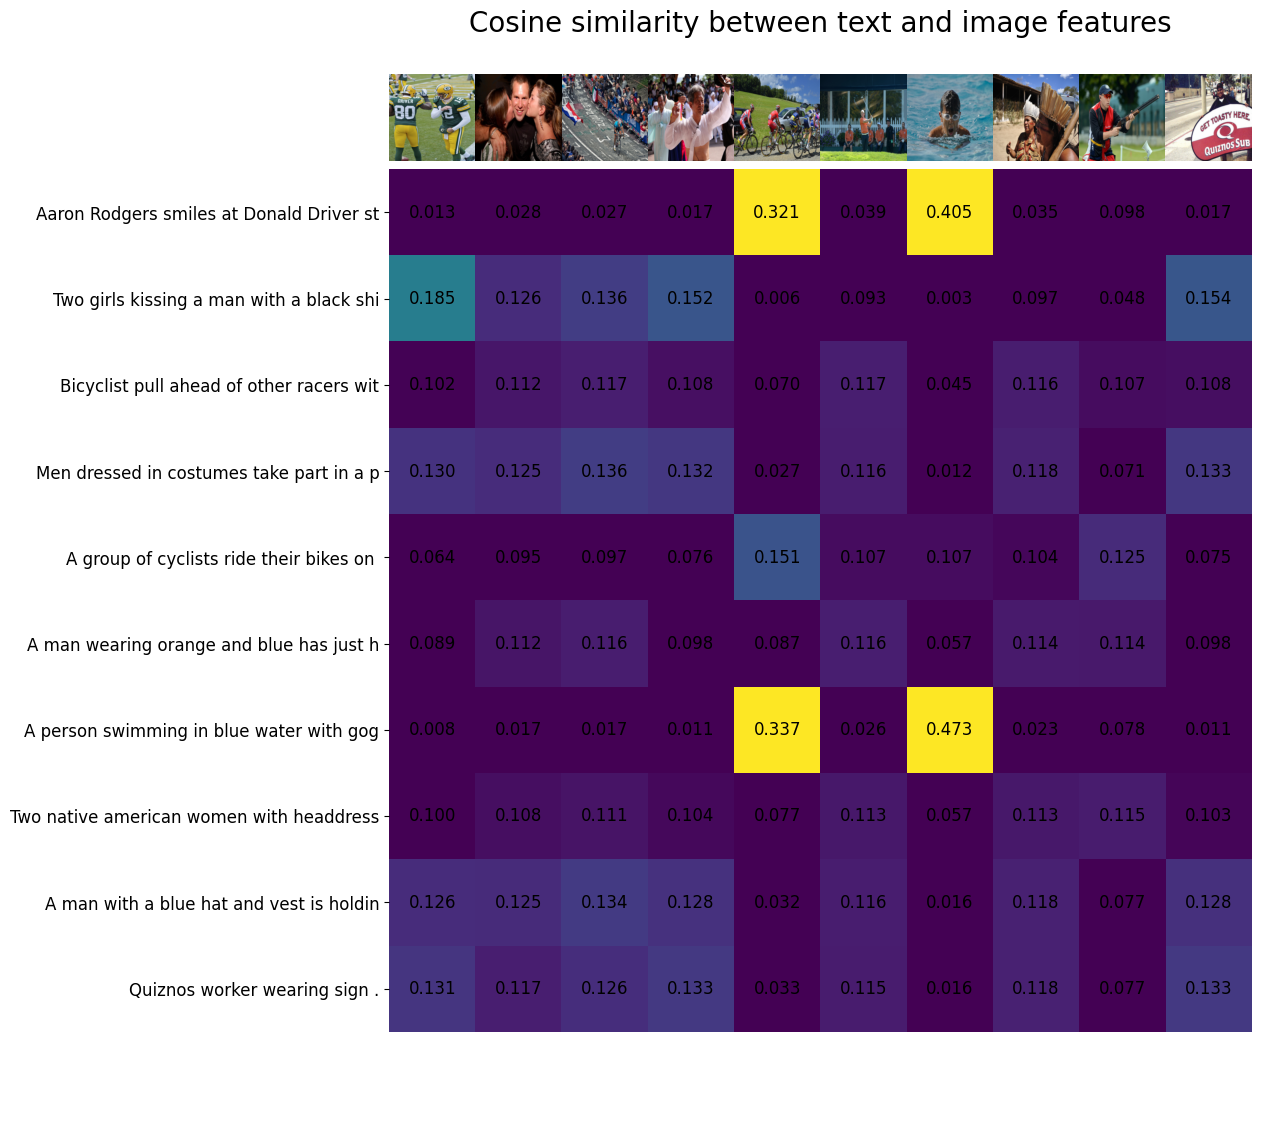

In [48]:
original_images = [VF.to_pil_image(img.detach()) for img in batch_img_tensor.cpu()]
labels = [
    model_trained.text_transformer.text_token_embedding.text_encoder.decode(
        target_tensor
    )
    .replace("<pad>", "")
    .replace("<bos>", "")[:40]
    for target_tensor in batch_target_tensor
]
count = len(original_images)
similarity = nn.Softmax(dim=-1)(img_contrastive_prob).cpu().detach()

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), labels, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

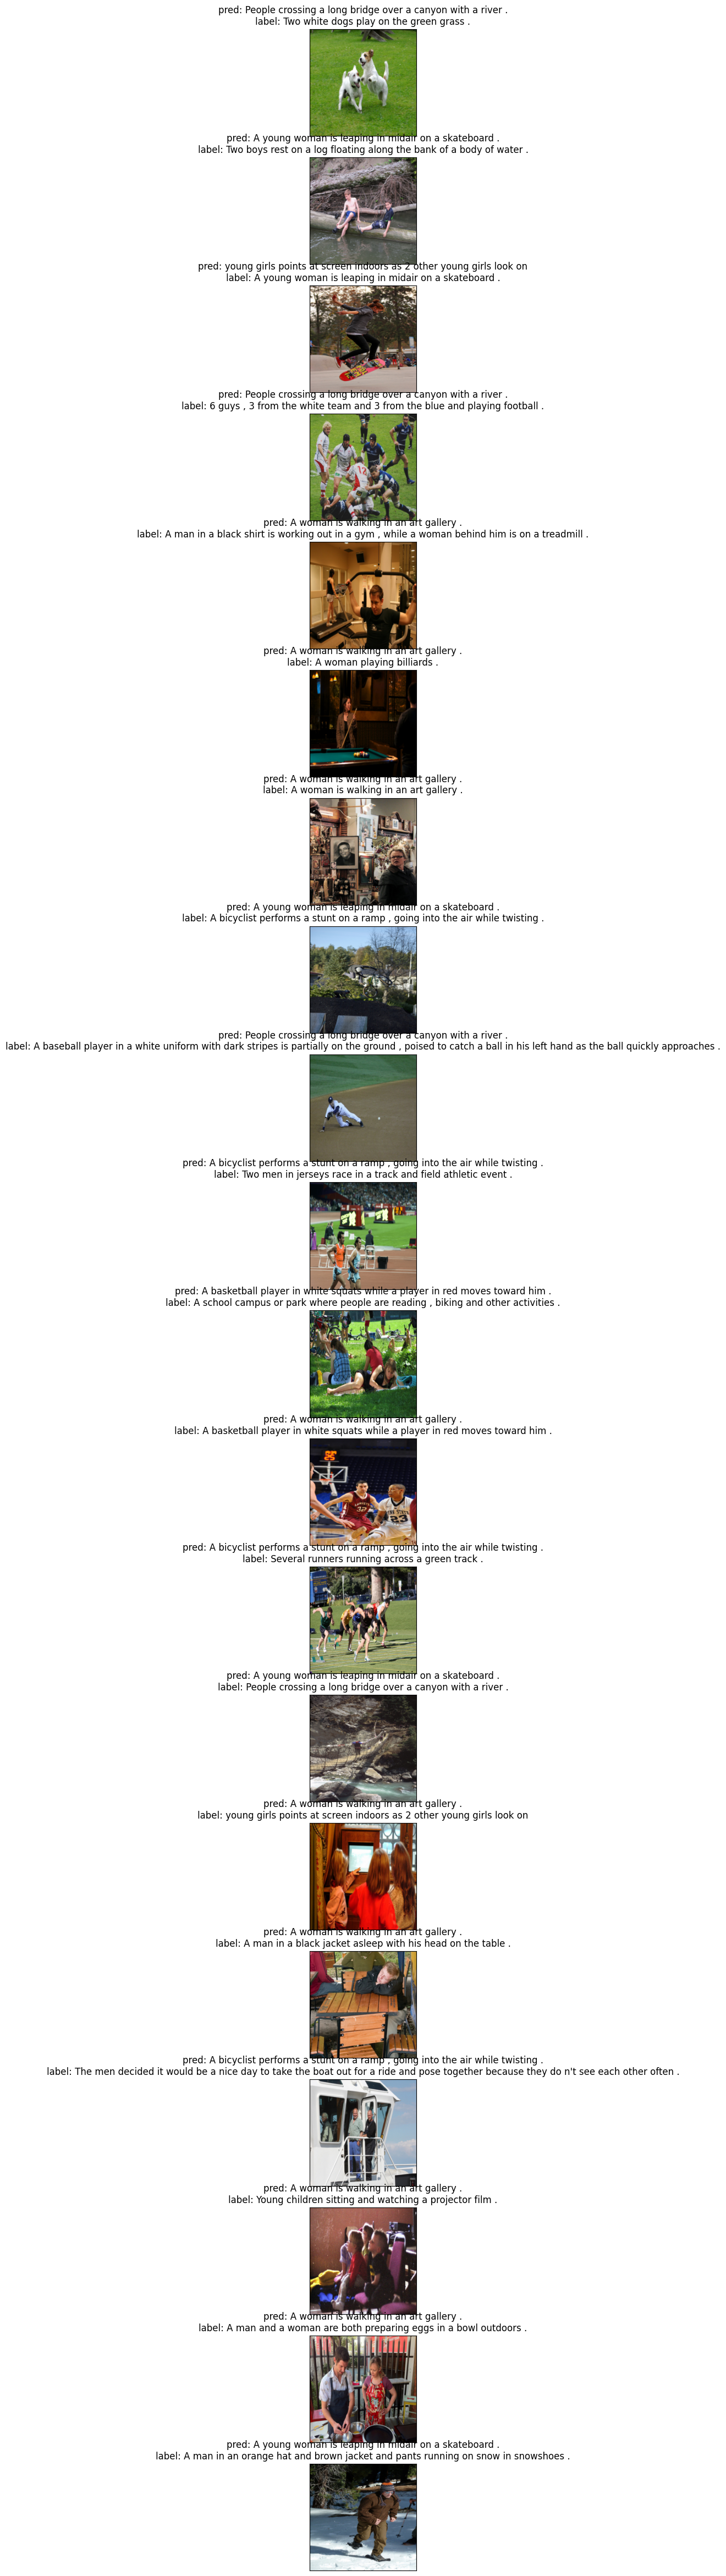

In [28]:
img_predicted_commments_index = torch.argmax(img_contrastive_prob, dim=1)

show(
    imgs=[img for img in batch_img_tensor.cpu()],
    labels=[
        model_trained.text_transformer.text_token_embedding.text_encoder.decode(
            target_tensor
        )
        for target_tensor in batch_target_tensor
    ],
    comments=[
        model_trained.text_transformer.text_token_embedding.text_encoder.decode(
            batch_target_tensor[predicted_comment_index]
        )
        for predicted_comment_index in img_predicted_commments_index
    ],
)